In [113]:
print("all ok")

all ok


In [114]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: /home/krishna/Documents/krishna/llmops_krishnaik/automated-research-report-generation


In [115]:
from research_and_analyst.utils.model_loader import ModelLoader

In [116]:
model_loader = ModelLoader()

{"timestamp": "2025-11-08T13:08:15.179840Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-11-08T13:08:15.181373Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-11-08T13:08:15.182064Z", "level": "info", "event": "ASTRA_DB_API_ENDPOINT loaded from environment"}
{"timestamp": "2025-11-08T13:08:15.182738Z", "level": "info", "event": "ASTRA_DB_APPLICATION_TOKEN loaded from environment"}
{"timestamp": "2025-11-08T13:08:15.183316Z", "level": "info", "event": "ASTRA_DB_KEYSPACE loaded from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-11-08T13:08:15.187385Z", "level": "info", "event": "YAML config loaded"}


In [117]:
llm = model_loader.load_llm()

{"provider": "google", "model": "gemini-2.0-flash", "timestamp": "2025-11-08T13:08:15.194323Z", "level": "info", "event": "Loading LLM"}
E0000 00:00:1762607295.213995  109713 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [118]:
llm.invoke("hi").content

'Hi there! How can I help you today?'

In [119]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [120]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

Analyst( name="Dr. Neha Patel", role="Medical Data Scientist", affiliation="Stanford Medicine", description="Focuses on predictive models for patient outcomes." ),

Analyst( name="Dr. Arun Verma", role="Ethics Researcher", affiliation="WHO", description="Explores ethical implications of AI in diagnostics." ), Analyst( name="Ms. Priya Sharma", role="Policy Analyst", affiliation="Ministry of Health", description="Investigates AI policy and compliance frameworks." )

In [121]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst")
    role: str = Field(description="Role of the analyst in the context of the topic")
    affiliation: str = Field(description="Primary affiliation of the analyst")
    description: str = Field(description="Description of the analyst: focus, concerns and motives")

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\ndescription: {self.description}"

In [122]:
analyst = Analyst(
    name="Krishna", 
    role="GenAI Engineer", 
    affiliation="AI Research Lab", 
    description="I am a GenAI developer."
)

In [123]:
analyst.name

'Krishna'

In [124]:
print(analyst.persona)

Name: Krishna
Role: GenAI Engineer
Affiliation: AI Research Lab
description: I am a GenAI developer.


In [125]:
Analyst(
    name="Dr. Neha Patel",
    role="Medical Data Scientist",
    affiliation="Stanford Medicine",
    description="Focuses on predictive models for patient outcomes."
)

Analyst(name='Dr. Neha Patel', role='Medical Data Scientist', affiliation='Stanford Medicine', description='Focuses on predictive models for patient outcomes.')

In [126]:
class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [127]:
class GenerateAnalystsState(TypedDict):
    topic: str    # research topic
    max_analysts: int    # number of analyst
    human_analyst_feedback: str    # human feedback
    analysts: List[Analyst]    # analyst asking questions

In [128]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [129]:
analyst_instructions = """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [130]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


In [131]:
def create_analyst(state: GenerateAnalystsState):
    """
    it is creating my analyst.
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    structured_llm = llm.with_structured_output(Perspectives)    # structured_llm will return an output in the form of Perspectives.

    system_messages = analyst_instructions.format(
        topic=topic, 
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
    )

    analysts = structured_llm.invoke([SystemMessage(content=system_messages)] + [HumanMessage(content="Generate the set of analysts.")])

    return {"analysts": analysts.analysts}

In [132]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

{'analysts': [Analyst(name='Dr. Emily Carter', role='Public Health Researcher', affiliation='National Institutes of Health', description='Focuses on preventative healthcare and health equity. Concerned about disparities in access to care and the social determinants of health. Motivated by improving population health outcomes.'),
  Analyst(name='Dr. David Chen', role='Healthcare Policy Analyst', affiliation='Center for Healthcare Economics', description='Specializes in healthcare financing and policy. Concerned about the rising costs of healthcare and the impact of policy changes on access and quality. Motivated by promoting efficient and effective healthcare systems.')]}

In [133]:
def human_feedback(state):
    """
    No-op node that should be interrupted on
    """
    pass

In [134]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END

In [135]:
# to display the graph
from IPython.display import Image, display

## First Workflow

In [136]:
builder = StateGraph(GenerateAnalystsState)

In [137]:
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)

In [138]:
builder.add_edge(START, "create_analyst")

In [139]:
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback", 
                              should_continue, 
                              ["create_analyst", 
                               END])

In [140]:
memory = MemorySaver()

In [141]:
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

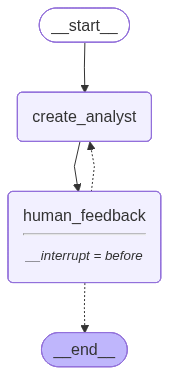

In [142]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [143]:
topic = "the benefits of adopting Langgraph as an agent framework"

In [144]:
max_analysts = 4

In [145]:
thread =  {"configurable":{"thread_id":1}}

In [146]:
for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    analysts = event.get("analysts", "")

    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Alice Chen
Affiliation: Tech Solutions Inc.
Role: AI Infrastructure Engineer
Description: Focuses on the practical aspects of integrating Langgraph into existing systems. Concerned with scalability, cost-effectiveness, and ease of deployment. Motivated by improving the efficiency and reliability of AI infrastructure.
--------------------------------------------------
Name: Bob Johnson
Affiliation: Global AI Institute
Role: AI Research Scientist
Description: Interested in Langgraph's potential to advance AI research. Explores its capabilities for complex reasoning, multi-agent collaboration, and knowledge discovery. Motivated by pushing the boundaries of AI and creating more intelligent systems.
--------------------------------------------------
Name: Charlie Garcia
Affiliation: Innovate AI Corp.
Role: AI Product Manager
Description: Evaluates Langgraph from a product perspective. Focuses on its potential to create new AI-powered products and services. Concerned with user experien

In [147]:
state = graph.get_state(thread)

In [148]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Alice Chen', role='AI Infrastructure Engineer', affiliation='Tech Solutions Inc.', description='Focuses on the practical aspects of integrating Langgraph into existing systems. Concerned with scalability, cost-effectiveness, and ease of deployment. Motivated by improving the efficiency and reliability of AI infrastructure.'), Analyst(name='Bob Johnson', role='AI Research Scientist', affiliation='Global AI Institute', description="Interested in Langgraph's potential to advance AI research. Explores its capabilities for complex reasoning, multi-agent collaboration, and knowledge discovery. Motivated by pushing the boundaries of AI and creating more intelligent systems."), Analyst(name='Charlie Garcia', role='AI Product Manager', affiliation='Innovate AI Corp.', description='Evaluates Langgraph from a product perspective. Focuses on its potential to crea

In [149]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'analysts': [Analyst(name='Alice Chen', role='AI Infrastructure Engineer', affiliation='Tech Solutions Inc.', description='Focuses on the practical aspects of integrating Langgraph into existing systems. Concerned with scalability, cost-effectiveness, and ease of deployment. Motivated by improving the efficiency and reliability of AI infrastructure.'),
  Analyst(name='Bob Johnson', role='AI Research Scientist', affiliation='Global AI Institute', description="Interested in Langgraph's potential to advance AI research. Explores its capabilities for complex reasoning, multi-agent collaboration, and knowledge discovery. Motivated by pushing the boundaries of AI and creating more intelligent systems."),
  Analyst(name='Charlie Garcia', role='AI Product Manager', affiliation='Innovate AI Corp.', description='Evaluates Langgraph from a product perspective. Focuses on its potential to create new AI-power

In [150]:
state.next

('human_feedback',)

In [151]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0bca3f-eb10-66cc-bfff-edf95ce89560': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-11-08T13:08:18.719050+00:00\xa2id\xd9$1f0bca3f-eb10-66cc-bfff-edf95ce89560\xb0channel_versions\x81\xa9__start__\xd9400000000000000000000000000000001.0.18091687656552113\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0bca3f-eb14-6b5b-8000-338e51d4d2a3': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-11-08T13:08:18.720827+00:00\xa2id\xd9$1f0bca3f-eb14-6b5b-8000-338e51d4d2a3\xb0channel_versions\x84\xa9__start__\xd9300000000000000000000000000000002.0.5470973353200842\xa5topic\xd9300000000000000000000000000000002.0.5470973353200842\xacmax_analysts\xd9300000000000000000000000000000002.0.5470973353200842\xb8branch:to:create_analyst\xd9300000000000000000000000000000002.0.5470973353200842\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start__\x

In [152]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0bca40-0878-63cc-8001-764d495caea1'}}

In [153]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"}, as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0bca40-094d-6de1-8002-5314a3434c58'}}

In [154]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Alice Chen
Affiliation: Tech Solutions Inc.
Role: AI Infrastructure Engineer
Description: Focuses on the practical aspects of integrating Langgraph into existing systems. Concerned with scalability, cost-effectiveness, and ease of deployment. Motivated by improving the efficiency and reliability of AI infrastructure.
--------------------------------------------------
Name: Bob Johnson
Affiliation: Global AI Institute
Role: AI Research Scientist
Description: Interested in Langgraph's potential to advance AI research. Explores its capabilities for complex reasoning, multi-agent collaboration, and knowledge discovery. Motivated by pushing the boundaries of AI and creating more intelligent systems.
--------------------------------------------------
Name: Charlie Garcia
Affiliation: Innovate AI Corp.
Role: AI Product Manager
Description: Evaluates Langgraph from a product perspective. Focuses on its potential to create new AI-powered products and services. Concerned with user experien

In [155]:
state = graph.get_state(thread)

In [156]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Ava Chen', role='Startup CTO', affiliation='InnovateAI Solutions', description='Focuses on rapid prototyping and deployment of AI solutions. Concerned with the agility and scalability of Langgraph for quickly iterating on agent-based products and achieving product-market fit. Motivated by the potential to disrupt traditional markets with innovative AI applications.'), Analyst(name='Dr. Jian Li', role='Enterprise AI Architect', affiliation='GlobalTech Enterprises', description='Responsible for designing and implementing AI infrastructure for large organizations. Focuses on the robustness, security, and compliance of Langgraph in enterprise settings. Concerned with seamless integration with existing systems and ensuring data privacy. Mo

In [157]:
state.next

('human_feedback',)

In [158]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Ava Chen', role='Startup CTO', affiliation='InnovateAI Solutions', description='Focuses on rapid prototyping and deployment of AI solutions. Concerned with the agility and scalability of Langgraph for quickly iterating on agent-based products and achieving product-market fit. Motivated by the potential to disrupt traditional markets with innovative AI applications.'),
  Analyst(name='Dr. Jian Li', role='Enterprise AI Architect', affiliation='GlobalTech Enterprises', description='Responsible for designing and implementing AI infrastructure for large organizations. Focuses on the robustness, security, and compliance of Langgraph in enterprise settings. Concerned with seamless integration with existing systems and ensuring data privacy. Motivated by drivi

In [159]:
further_feedack = ""

In [160]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config

In [161]:
# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0bca40-2882-608a-8006-307552e7fba9'}}

In [162]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)

()


In [163]:
analysts = final_state.values.get('analysts')
analysts

[Analyst(name='Ava Chen', role='Startup CTO', affiliation='InnovateAI Solutions', description='Focuses on rapid prototyping and deployment of AI solutions. Concerned with the agility and scalability of Langgraph for quickly iterating on agent-based products and achieving product-market fit. Motivated by the potential to disrupt traditional markets with innovative AI applications.'),
 Analyst(name='Dr. Jian Li', role='Enterprise AI Architect', affiliation='GlobalTech Enterprises', description='Responsible for designing and implementing AI infrastructure for large organizations. Focuses on the robustness, security, and compliance of Langgraph in enterprise settings. Concerned with seamless integration with existing systems and ensuring data privacy. Motivated by driving efficiency and innovation through AI at scale.'),
 Analyst(name='Sarah Miller', role='AI Research Scientist', affiliation='AI Research Institute', description='Conducts research on advanced AI techniques and agent-based s

In [164]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Ava Chen
Affiliation: InnovateAI Solutions
Role: Startup CTO
Description: Focuses on rapid prototyping and deployment of AI solutions. Concerned with the agility and scalability of Langgraph for quickly iterating on agent-based products and achieving product-market fit. Motivated by the potential to disrupt traditional markets with innovative AI applications.
--------------------------------------------------
Name: Dr. Jian Li
Affiliation: GlobalTech Enterprises
Role: Enterprise AI Architect
Description: Responsible for designing and implementing AI infrastructure for large organizations. Focuses on the robustness, security, and compliance of Langgraph in enterprise settings. Concerned with seamless integration with existing systems and ensuring data privacy. Motivated by driving efficiency and innovation through AI at scale.
--------------------------------------------------
Name: Sarah Miller
Affiliation: AI Research Institute
Role: AI Research Scientist
Description: Conducts r

In [165]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="The benefits of adopting LangGraph as an agent framework").load()
print(docs[0].page_content[:500])

The Semantic Web, sometimes known as Web 3.0, is an extension of the World Wide Web through standards set by the World Wide Web Consortium (W3C). The goal of the Semantic Web is to make Internet data machine-readable.
To enable the encoding of semantics with the data, technologies such as Resource Description Framework (RDF) and Web Ontology Language (OWL) are used. These technologies are used to formally represent metadata. For example, ontology can describe concepts, relationships between enti


In [166]:
from langchain_community.utilities import WikipediaAPIWrapper

wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=4000)
docs = wiki.run("The benefits of adopting LangGraph as an agent framework")
print(docs)

Page: Semantic Web
Summary: The Semantic Web, sometimes known as Web 3.0, is an extension of the World Wide Web through standards set by the World Wide Web Consortium (W3C). The goal of the Semantic Web is to make Internet data machine-readable.
To enable the encoding of semantics with the data, technologies such as Resource Description Framework (RDF) and Web Ontology Language (OWL) are used. These technologies are used to formally represent metadata. For example, ontology can describe concepts, relationships between entities, and categories of things. These embedded semantics offer significant advantages such as reasoning over data and operating with heterogeneous data sources.
These standards promote common data formats and exchange protocols on the Web, fundamentally the RDF. According to the W3C, "The Semantic Web provides a common framework that allows data to be shared and reused across application, enterprise, and community boundaries." The Semantic Web is therefore regarded as

## Second Workflow

In [167]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [168]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [169]:
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

In [170]:
tavily_search.invoke("langgraph")

[{'title': 'What is LangGraph? - GeeksforGeeks',
  'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
  'content': '# What is LangGraph?\n\nLast Updated : \n10 Oct, 2025\n\nSuggest changes\n\n1 Likes\n\nLangGraph is an open-source framework built by LangChain that streamlines the creation and management of AI agent workflows. At its core, LangGraph combines large language models (LLMs) with graph-based architectures allowing developers to map, organize and optimize how AI agents interact and make decisions.',
  'score': 0.9345448},
 {'title': 'LangGraph overview - Docs by LangChain',
  'url': 'https://docs.langchain.com/oss/javascript/langgraph/overview',
  'content': "Trusted by companies shaping the future of agents— including Klarna, Replit, Elastic, and more— LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents. LangGraph is very low-level, and focused entirely on agent orchestratio

In [171]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


In [172]:
from typing import Annotated
import operator
from langgraph.graph import MessagesState

In [173]:
class InterviewState(MessagesState):
    max_num_turns: int    # number of turns of conversation
    context: Annotated[list, operator.add]    # source docs
    analyst: Analyst    # analyst asking questions
    interview: str    # interview transcript
    sections: list    # final key we duplicate in outer state for Send() API

In [174]:
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval")

In [175]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is to boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalitites and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by intoducing yourself to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you.

"""

In [176]:
def generate_question(state: InterviewState):
    """
    Node to generate question
    """
    # get state
    analyst = state["analyst"]
    messages = state["messages"]

    # generate the question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    # return the question through state
    return {"messages": [question]}

In [177]:
analyst

Analyst(name='Tom Williams', role='AI Product Manager', affiliation='ProductAI Inc.', description='Manages the development and launch of AI-powered products. Focuses on the user experience and business value of Langgraph-based applications. Concerned with the ease of use, accessibility, and impact on key business metrics. Motivated by creating successful AI products that solve real-world problems.')

In [178]:
state = {"max_num_turns": 2, "context": [], "analyst": analyst, "interview": "", "section": [], "messages": [HumanMessage(content="hi fo the proper search according to the expertise")]}
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name='Tom Williams', role='AI Product Manager', affiliation='ProductAI Inc.', description='Manages the development and launch of AI-powered products. Focuses on the user experience and business value of Langgraph-based applications. Concerned with the ease of use, accessibility, and impact on key business metrics. Motivated by creating successful AI products that solve real-world problems.'),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='hi fo the proper search according to the expertise', additional_kwargs={}, response_metadata={})]}

In [179]:
result = generate_question(state)

In [180]:
result

{'messages': [AIMessage(content='Okay, great! Hi Tom, I\'m an analyst working on understanding the current landscape of AI product development, specifically focusing on Langgraph-based applications. I\'m really interested in getting your perspective as an AI Product Manager at ProductAI Inc.\n\nTo make sure I\'m targeting the right areas, could you tell me a bit more about the types of Langgraph-based applications you\'re currently working on or have recently launched? I\'m particularly interested in understanding:\n\n*   **The specific problem(s) these applications are solving.** Are we talking about customer service automation, internal knowledge management, content generation, or something else entirely?\n*   **The target user(s) for these applications.** Are they internal employees, external customers, or a mix?\n*   **The key business metrics you\'re tracking to measure the success of these applications.** What does "success" look like in your context?\n\nUnderstanding these detai

In [181]:
print(result["messages"][0].content)

Okay, great! Hi Tom, I'm an analyst working on understanding the current landscape of AI product development, specifically focusing on Langgraph-based applications. I'm really interested in getting your perspective as an AI Product Manager at ProductAI Inc.

To make sure I'm targeting the right areas, could you tell me a bit more about the types of Langgraph-based applications you're currently working on or have recently launched? I'm particularly interested in understanding:

*   **The specific problem(s) these applications are solving.** Are we talking about customer service automation, internal knowledge management, content generation, or something else entirely?
*   **The target user(s) for these applications.** Are they internal employees, external customers, or a mix?
*   **The key business metrics you're tracking to measure the success of these applications.** What does "success" look like in your context?

Understanding these details will help me focus our conversation and extr

In [182]:
from langchain_core.messages import get_buffer_string

In [183]:
# search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert.
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
Firstly, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query.
""")

In [184]:
def search_web(state: InterviewState):
    """
    Retrieve data from the web
    """
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state["messages"])

    # web search
    search_docs = tavily_search.invoke(search_query.search_query)

    # format
    formatted_search_docs = "\n\n----\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [185]:
state = {"max_num_turns": 2, "context": [], "analyst": analyst, "interview": "", "section": [], 'messages': [AIMessage(content='Okay, great! Hi Carlos, my name is [Your Name], and I\'m an analyst working on understanding the current landscape and future potential of Langgraph-based solutions, particularly from a product and market adoption perspective.\n\nI understand you\'re an AI Product Manager at DataWise Analytics, focusing on developing and launching AI-powered products. That makes you the perfect person to talk to!\n\nTo make sure I\'m focusing my questions in the right area, could you tell me a bit more about the specific types of Langgraph-based solutions you\'re currently working with or have experience with? Are we talking about things like:\n\n*   **Complex conversational AI agents?** (e.g., multi-turn dialogues, agents that can handle interruptions and context switching)\n*   **Automated workflows and decision-making systems?** (e.g., using Langgraph to orchestrate different AI models and tools for tasks like fraud detection or risk assessment)\n*   **Something else entirely?**\n\nAlso, when you think about "usability and market adoption," what are the *biggest* challenges that come to mind for you with Langgraph specifically? This will help me narrow down my focus and ask more relevant questions.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--cb7d6132-1cc5-4521-a9ed-bf873c98265d-0', usage_metadata={'input_tokens': 215, 'output_tokens': 253, 'total_tokens': 468, 'input_token_details': {'cache_read': 0}})]}

In [186]:
result = search_web(state)
result

{'context': ['<Document href="https://www.linkedin.com/posts/susil-j_agenticai-langgraph-aiimplementation-activity-7380595306687598592-T8-q"/>\nThe persistent ambition to create truly adaptive enterprise software—systems capable of autonomously modifying their behavior and structure in response to dynamic environments—has largely remained unfulfilled. While research has produced sophisticated control loop architectures and adaptive algorithms, their adoption in complex enterprise settings is fraught with challenges. The primary impediment isn’t procedural but ontological. The prevailing architectural paradigm, rooted in highly [...] The 5 hidden challenges of LangGraph no one talks about: LangGraph has quickly become the premier framework for building sophisticated AI agents - but my conversations with dozens of developers reveal consistent implementation hurdles that aren\'t addressed in tutorials. 1. API Infrastructure Gaps The open-source version lacks built-in API endpoints, forcin

In [187]:
print(result["context"][0])

<Document href="https://www.linkedin.com/posts/susil-j_agenticai-langgraph-aiimplementation-activity-7380595306687598592-T8-q"/>
The persistent ambition to create truly adaptive enterprise software—systems capable of autonomously modifying their behavior and structure in response to dynamic environments—has largely remained unfulfilled. While research has produced sophisticated control loop architectures and adaptive algorithms, their adoption in complex enterprise settings is fraught with challenges. The primary impediment isn’t procedural but ontological. The prevailing architectural paradigm, rooted in highly [...] The 5 hidden challenges of LangGraph no one talks about: LangGraph has quickly become the premier framework for building sophisticated AI agents - but my conversations with dozens of developers reveal consistent implementation hurdles that aren't addressed in tutorials. 1. API Infrastructure Gaps The open-source version lacks built-in API endpoints, forcing developers to 

In [188]:
def search_wikipedia(state: InterviewState):
    """
    Retrieve data from wikipedia
    """
    # search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state["messages"])
    print(f"search_query: {search_query}")

    # search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()
    print(f"search_docs: {search_docs}")

    # format
    formatted_search_docs = "\n\n----\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [189]:
state = {"max_num_turns": 2, "context": [], "analyst": analyst, "interview": "", "section": [], 'messages': [AIMessage(content='Okay, great! Hi Carlos, my name is [Your Name], and I\'m an analyst working on understanding the current landscape and future potential of Langgraph-based solutions, particularly from a product and market adoption perspective.\n\nI understand you\'re an AI Product Manager at DataWise Analytics, focusing on developing and launching AI-powered products. That makes you the perfect person to talk to!\n\nTo make sure I\'m focusing my questions in the right area, could you tell me a bit more about the specific types of Langgraph-based solutions you\'re currently working with or have experience with? Are we talking about things like:\n\n*   **Complex conversational AI agents?** (e.g., multi-turn dialogues, agents that can handle interruptions and context switching)\n*   **Automated workflows and decision-making systems?** (e.g., using Langgraph to orchestrate different AI models and tools for tasks like fraud detection or risk assessment)\n*   **Something else entirely?**\n\nAlso, when you think about "usability and market adoption," what are the *biggest* challenges that come to mind for you with Langgraph specifically? This will help me narrow down my focus and ask more relevant questions.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--cb7d6132-1cc5-4521-a9ed-bf873c98265d-0', usage_metadata={'input_tokens': 215, 'output_tokens': 253, 'total_tokens': 468, 'input_token_details': {'cache_read': 0}})]}

In [190]:
result = search_wikipedia(state)    # getting empty search docs from wikipedia for this query
result

search_query: search_query='challenges of Langgraph usability and market adoption'
search_docs: []


{'context': ['']}

In [191]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [192]:
def generate_answer(state: InterviewState):
    """
    Node to answer a question
    """
    # get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # answer question
    system_message = question_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # name the message as coming from expert
    answer.name = "expert"

    # append it to state
    return {"messages": [answer]}

In [193]:
def router_messages(state: InterviewState,
                    name: str = "expert"):
    """
    Route between question and answer
    """
    # get messages
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    # check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # end if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "save_interview"
    
    # this router is run after each question - answer pair 
    # get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

In [194]:
def save_interview(state: InterviewState):
    """
    Save interviews
    """
    # get messages
    messages = state["messages"]

    # convert interview to a string
    interview = get_buffer_string(messages)

    # save to interview key
    return {"interview": interview}

In [195]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [196]:
def write_section(state: InterviewState):
    """
    """
    # get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # append it to state
    return {"sections": [section.content]}

In [197]:
interview_builder = StateGraph(InterviewState)

In [198]:
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("generate_answer", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

In [199]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "generate_answer")
interview_builder.add_edge("search_wikipedia", "generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           router_messages,
                           ["ask_question",
                           "save_interview"])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

In [200]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interview")

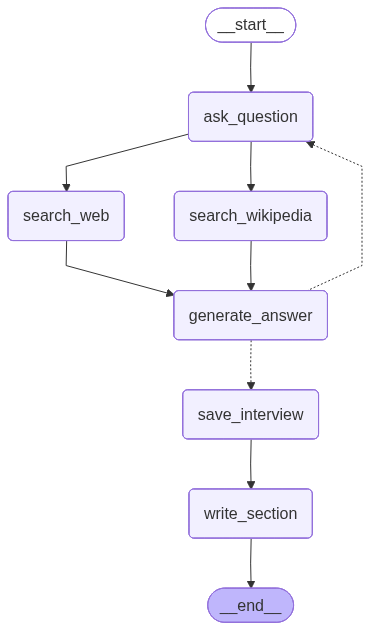

In [201]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [202]:
analyst

Analyst(name='Tom Williams', role='AI Product Manager', affiliation='ProductAI Inc.', description='Manages the development and launch of AI-powered products. Focuses on the user experience and business value of Langgraph-based applications. Concerned with the ease of use, accessibility, and impact on key business metrics. Motivated by creating successful AI products that solve real-world problems.')

In [203]:
from IPython.display import Markdown

In [204]:
messages = [HumanMessage("So you said you were writing an article on Langchain?")]

In [205]:
thread = {"configurable": {"thread_id": "1"}}

In [206]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

search_query: search_query='Langgraph vs Langchain chains product perspective'
search_docs: []
search_query: search_query='Langgraph vs Langchain chains architecture'
search_docs: []


In [207]:
Markdown(interview["sections"][0])

## LangGraph: The UX-Focused Evolution of LangChain for Complex AI Products

### Summary

LangChain and LangGraph are both frameworks developed by the LangChain team for building applications powered by Large Language Models (LLMs), but they cater to different needs and complexities [1], [3], [6]. LangChain is designed as a flexible and modular toolkit, ideal for rapid prototyping, simpler, linear workflows, and applications requiring diverse external connections [1], [2], [3], [5]. It allows for quick integration with LLMs and various tools, making it accessible for beginners and suitable for projects that need a fast setup [5], [6]. LangChain excels in scenarios where the focus is on ease of use and quick deployment, such as simple chatbots or Retrieval-Augmented Generation (RAG) pipelines [2], [7].

LangGraph, on the other hand, is engineered for production-grade, complex, multi-agent workflows with dynamic control flows [2], [5]. It extends LangChain by providing a graph-based architecture that supports stateful applications, intricate decision-making processes, and the coordination of multiple agents [1], [7]. LangGraph's strength lies in its ability to manage context across multiple interactions, making it suitable for applications that require memory and the ability to adapt based on past interactions, such as sophisticated virtual assistants [4]. It offers built-in control for branching decisions, looping, retrying steps, and waiting for external input [3].

While LangChain is excellent for getting started quickly and handling simpler tasks, LangGraph is the preferred choice for projects that demand a higher degree of control, state management, and the ability to handle complex, dynamic workflows [3], [5]. LangChain agents are built on top of LangGraph to provide durable execution, streaming, human-in-the-loop, persistence, and more [6]. The frameworks are complementary, allowing developers to prototype quickly with LangChain and then integrate those chains into a LangGraph node for more complex workflows [3], [7].

### Sources

[1] https://oxylabs.io/blog/langgraph-vs-langchain
[2] https://duplocloud.com/blog/langchain-vs-langgraph/
[3] https://www.designveloper.com/blog/langgraph-vs-langchain-comparison/
[4] https://medium.com/@tahirbalarabe2/%EF%B8%8flangchain-vs-langgraph-a-comparative-analysis-ce7749a80d9c
[5] https://kanerika.com/blogs/langchain-vs-langgraph/
[6] https://js.langchain.com/docs/concepts/architecture/
[7] https://milvus.io/blog/langchain-vs-langgraph.md

## Third Workflow

In [208]:
class ResearchGraphState:
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]
    sections: Annotated[list, operator.add]    # send API key
    introduction: str    # introduction for the final report
    content: str    # content for the final report
    conclusion: str    # conclusion for the final report
    final_report: str    # final report

In [209]:
from langgraph.types import Send

In [210]:
def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API. """

    # check if human feedback
    human_analyst_feedback = state.get("human_analyst_feedback")
    if human_analyst_feedback:
        # return to create_analyst
        return "create_analyst"
    
    # otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", { "analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )]}) for analyst in state["analysts"]]

In [211]:
# def write_report(state: ResearchGraphState):
#     """
#     """
#     pass

In [212]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [ ]:
def write_report(state: ResearchGraphState):
    # full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos")])
    return {"content": report.content} 

In [214]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [215]:
def write_introduction(state: ResearchGraphState):
    # full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # summarize the sections into a final report
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")])
    return {"introduction": intro.content} 

In [216]:
def write_conclusion(state: ResearchGraphState):
    # full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # summarize the sections into a final report
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"conclusion": conclusion.content} 

In [217]:
def finalize_report(state: ResearchGraphState):
    """ This is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n----\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

In [221]:
# add nodes and edges
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

# logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)


In [222]:
memory = MemorySaver()

In [223]:
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

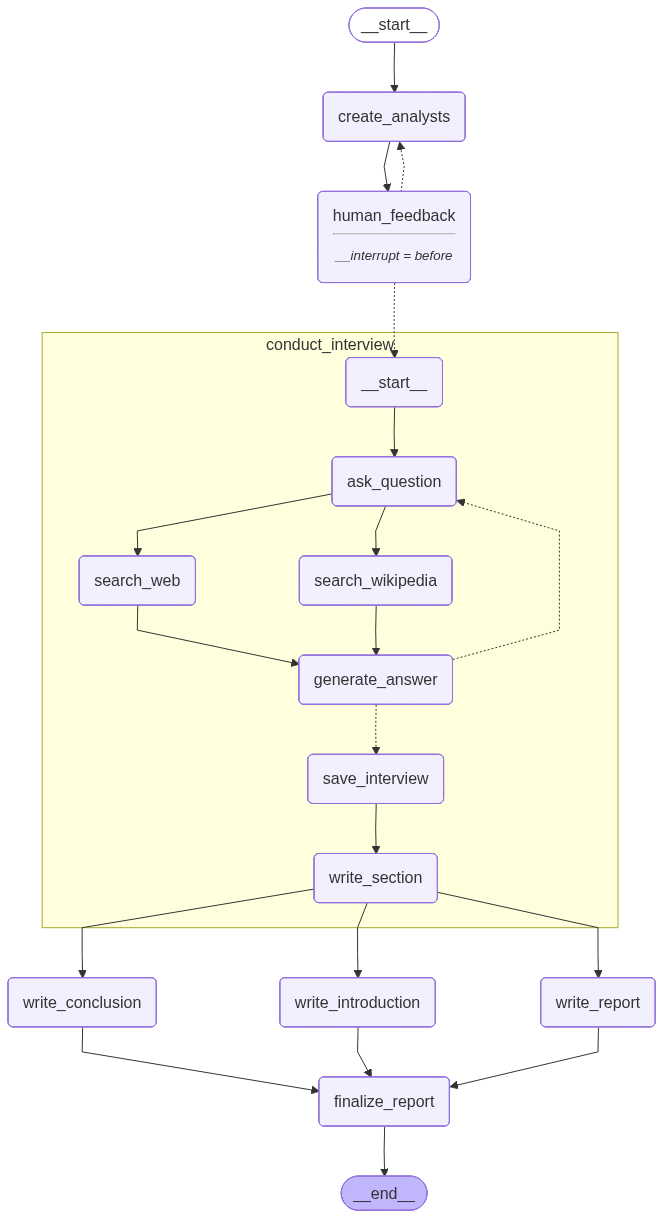

In [224]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))